# **Model Evalutation**

## Objectives

* Augment images to improve model performance
* Create binary classification model and train model using training dataset
* Validate model performance using validation dataset
* Test model performance using test model data
* Analyse model performance using a number of different metrics

## Inputs

* train, test and validation datasets

## Outputs

* Output the best model


# Import packages

In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

---

# Change working directory

* We are assuming you will store the notebooks in a subfolder, therefore when running the notebook in the editor, you will need to change the working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [2]:
import os
current_dir = os.getcwd()
current_dir

'/workspace/project-5/jupyter_notebooks'

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [3]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [4]:
current_dir = os.getcwd()
current_dir

'/workspace/project-5'

# Set input directories

In [5]:
data_dir = 'inputs/cherry_leaves_dataset/cherry-leaves'
train_dir = data_dir + '/train/'
val_dir = data_dir + '/validation/'
test_dir = data_dir + '/test/'

# Set output directories

In [6]:
version_num = 'v1'
output_dir = f'outputs/{version_num}'

if os.path.exists(output_dir):
    print('Output already exists - please pick a new version number if you want to create a new output directory')
else:
    os.makedirs(output_dir)
    print(f'Output {version_num} created')

Output already exists - please pick a new version number if you want to create a new output directory


# Set labels

In [7]:
labels = os.listdir(train_dir)
print('Image labels are: ', labels)

Image labels are:  ['healthy', 'powdery_mildew']


# Set image shape

In [8]:
import joblib
image_shape = joblib.load(f'outputs/{version_num}/image_shape.pkl')
image_shape

(256, 256, 3)

---

# Plot number of images in each group

* train - healthy: 1472 images
* test - healthy: 422 images
* validation - healthy: 210 images
* train - powdery_mildew: 1472 images
* test - powdery_mildew: 422 images
* validation - powdery_mildew: 210 images


Text(0.5, 1.0, 'Cherry leaves dataset distribution')

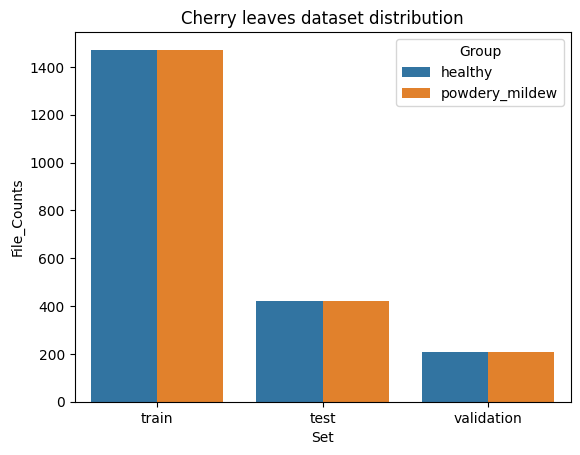

In [11]:
file_counts, data_split, group = [], [], []

for label in labels:
    for i in ['train', 'test', 'validation']:
        file_path = os.path.join(data_dir, i, label)
        files = os.listdir(file_path)
        num_files = len(files)
        file_counts.append(num_files)
        data_split.append(i)
        group.append(label)
        
        print(f'* {i} - {label}: {len(os.listdir(file_path))} images')

df = pd.DataFrame({'Set': data_split, 'Group': group, 'File_Counts': file_counts})

sns.barplot(data=df, x='Set', y='File_Counts', hue='Group')
plt.title('Cherry leaves dataset distribution')

---

NOTE

* You may add as many sections as you want, as long as it supports your project workflow.
* All notebook's cells should be run top-down (you can't create a dynamic wherein a given point you need to go back to a previous cell to execute some task, like go back to a previous cell and refresh a variable content)

---

# Push files to Repo

* If you don't need to push files to Repo, you may replace this section with "Conclusions and Next Steps" and state your conclusions and next steps.

In [ ]:
import os
try:
    # create here your folder
    # os.makedirs(name='')
except Exception as e:
    print(e)
